In [25]:
# %%
##############################################################
############### Examining average performance with various MD perturbations
##############################################################
import glob
import matplotlib as mpl
import matplotlib
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



In [26]:
exp_name = 'add_vs_mul/MD_ablation'
results_folder = './../results/'
config_files = glob.glob(results_folder + exp_name + "/" + "config*")
log_files = glob.glob(results_folder + exp_name + "/" + "log*")


files = os.listdir( results_folder  + exp_name+'/')
log_files = [file for file in files if 'log' in file]
config_files = [file for file in files if 'config' in file]


exps = {0: 'MD intact', 1: 'Add gates', 2:'Mul gates', 3:'MD lesioned'}
variable_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 10, 15, 20, 25, 30, 40]
# variable_values =  [1.0,  3.0,  5.0, 10.0, 20.0, 40.0]

no_of_values = len(variable_values)
norm = mpl.colors.Normalize(vmin=min([1,no_of_values]), vmax=max([1,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('viridis')
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)


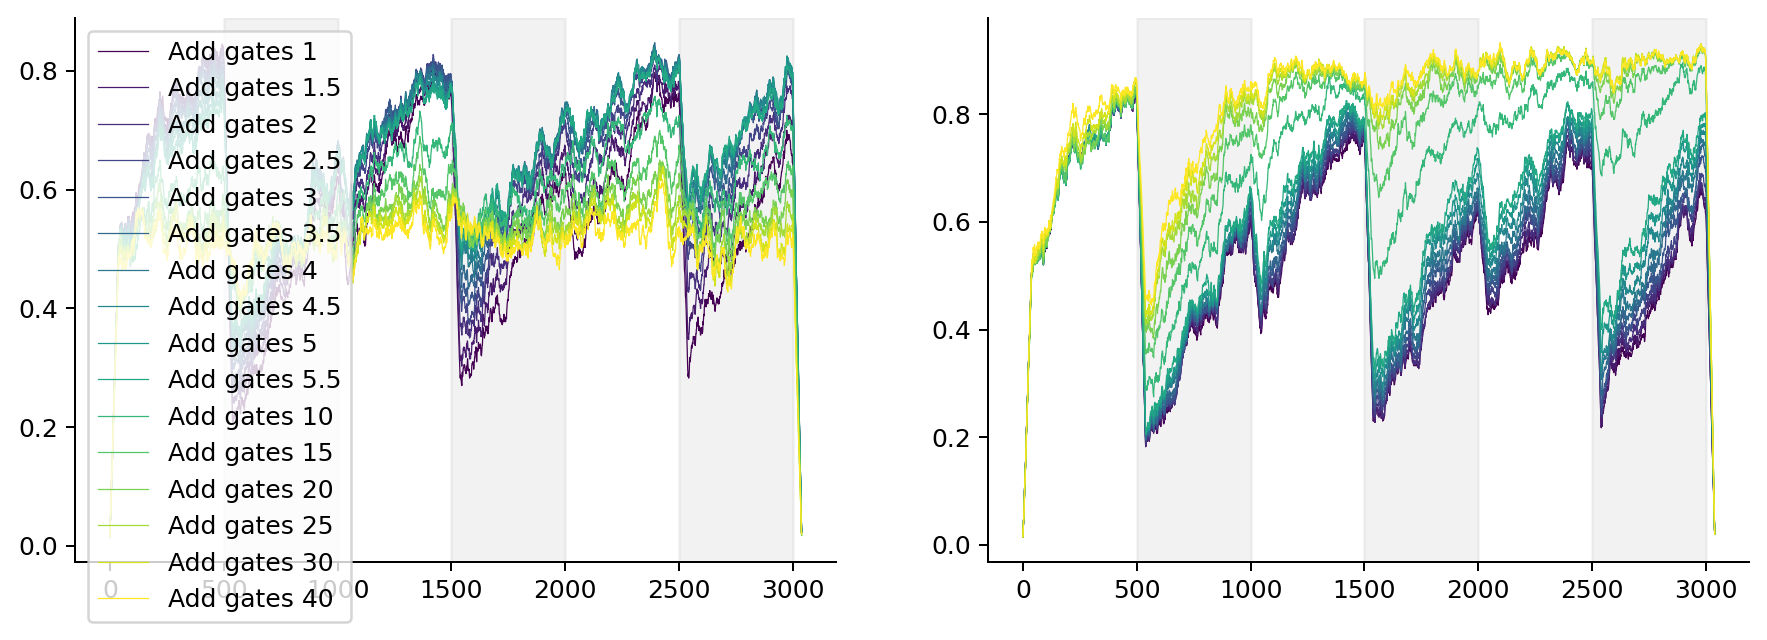

In [27]:

def get_perf_means(exp_to_run):
    vars = [(var1, var2) for var1 in [exp_to_run] for var2 in variable_values]
    # regexes = [f"\d_{float(var1):1.0f}_{float(var2):1.0f}_1.0" if var2%1==0 else f"\d_{float(var1):1.0f}_{float(var2):1.1f}_1.0" for var1, var2 in vars ]  
    regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_1.0" for var1, var2 in vars ]  
    labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

    means, stds, md_modulations = [], [], []
    means_all = [] # means pooled the other axis, pooling all trials for each run.
    for i, (label, regex) in enumerate(zip(labels, regexes)):
        comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
        conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
        if len(comp_files) > 0:
            # print('++++++++++++++++++++++++++++++\n',comp_files)
            performances, mods =[], []
            for log_file, config_file in zip (comp_files, conf_files):
                log = np.load(log_file, allow_pickle=True).item()
                if log.md_context_modulation > 0.8 : 
                    performances.append(log.corrects)
                    mods.append(log.md_context_modulation)
            smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='full') for performance in performances]
            sp = np.stack(smooth_performances)
            spmean = np.mean(sp, axis=0)    
            spstd = np.std(sp, axis=0)    
            means.append(spmean)
            means_all.append(sp.mean(1))
            stds.append(spstd)
            md_modulations.append(mods)
        else:
            print(f'no files found for {label}  regex {regex}')
    return (means, means_all, labels)

load_saved_data = False
# if not load_saved_data:
#     fig, axes = plt.subplots(1,2 , figsize=[12,4])

#     ax = axes[0]
#     means, means_all, labels = get_perf_means(1)
#     for i, (spmean, label) in enumerate(zip(means,labels)):
#         ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5, color=cmap.to_rgba(i+1),)
#     ax.legend()
#     tpb= 500
#     for ib in range(1, 6,2):
#         ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')

#     ax = axes[1]
#     means_2, means_all_2, labels_2 = get_perf_means(2)
#     for i, (spmean, label) in enumerate(zip(means_2,labels_2)):
#         ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5, color=cmap.to_rgba(i+1),)
    
#     for ib in range(1, 6,2):
#         ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')

In [28]:
# save and load for efficiency
if not load_saved_data:
    np.save('./data/means.npy', means)
    np.save('./data/means_2.npy', means_2)
    np.save('./data/means_all.npy', means_all)
    np.save('./data/means_all_2.npy', means_all_2)
    np.save ('./data/labels.npy', labels)

if load_saved_data:
    means = np.load('./data/means.npy', allow_pickle=True)
    means_2= np.load('./data/means_2.npy', allow_pickle=True)
    means_all = np.load('./data/means_all.npy', allow_pickle=True)
    means_all_2 = np.load('./data/means_all_2.npy',allow_pickle=True)
    labels = np.load ('./data/labels.npy', allow_pickle=True)


In [29]:
exp_name = 'add_vs_mul_data/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'Add gates', 2:'Mul gates', 3:'MD lesioned'}
# variable_values = [1,  1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 15, 20, 25, 30]

def get_correlations(exp_to_run):
    vars = [(var1, var2) for var1 in [exp_to_run] for var2 in variable_values]
    regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_1.0" for var1, var2 in vars]  
    labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

    m_nm_corrs, up_dn_corrs = [], []
    for i, (label, regex) in enumerate(zip (labels, regexes)):
        comp_files =  [os.path.join(file) for file in log_files if re.search(regex, file)]
        conf_files =  [os.path.join(file) for file in config_files if re.search(regex, file)]
        
        if len(comp_files) > 0:
            m_nm_corr, up_dn_corr = [], []
            for ii, (log_file, config_file) in enumerate(zip(comp_files, conf_files)):
                log = np.load(results_folder+exp_name+'/' +log_file, allow_pickle=True).item()
                config = np.load(results_folder+exp_name+'/' +config_file, allow_pickle=True).item()
                # find left vs right trials
                # calucalte corr using a few methods
                # up trials
                inputs = np.stack(log.Inputs)
                # idx_dn_m = np.argwhere(log.MDrates.mean(1)[:,1] * (inputs[:,0] == 0.))
                # idx_up_m = np.argwhere(log.MDrates.mean(1)[:,1] * (inputs[:,0] == 1.))
                # idx_up_nm = np.argwhere(log.MDrates.mean(1)[:,0] * (inputs[:,0] == 1.))
                # idx_dn_nm = np.argwhere(log.MDrates.mean(1)[:,0] * (inputs[:,0] == 0.))

                idx_up = np.argwhere((inputs[:,0] == 1.))
                idx_dn = np.argwhere((inputs[:,0] == 0.))

                #find m vs nm trials
                idx_m = np.argwhere(log.MDrates.mean(1)[:,1]) 
                idx_nm = np.argwhere(log.MDrates.mean(1)[:,0]) 

                trials_min = min( len(idx_up), len(idx_dn) )
                up_sig = log.PFCrates[idx_up[:trials_min], :, :].mean(2)
                dn_sig = log.PFCrates[idx_dn[:trials_min], :, :].mean(2)
                up_dn_corr.append(np.corrcoef(up_sig.reshape(-1), dn_sig.reshape(-1))[0,1])

                trials_min = min( len(idx_m), len(idx_nm) )
                m_sig = log.PFCrates[idx_m[:trials_min], :, :].mean(2)
                nm_sig = log.PFCrates[idx_nm[:trials_min], :, :].mean(2)
                m_nm_corr.append(np.corrcoef(m_sig.reshape(-1), nm_sig.reshape(-1))[0,1])
            m_nm_corrs.append(m_nm_corr)
            up_dn_corrs.append(up_dn_corr)
    return (m_nm_corrs, up_dn_corrs)


In [30]:

m_nm_corrs, up_dn_corrs = get_correlations(1)
m_nm_corrs2, up_dn_corrs2 = get_correlations(2)



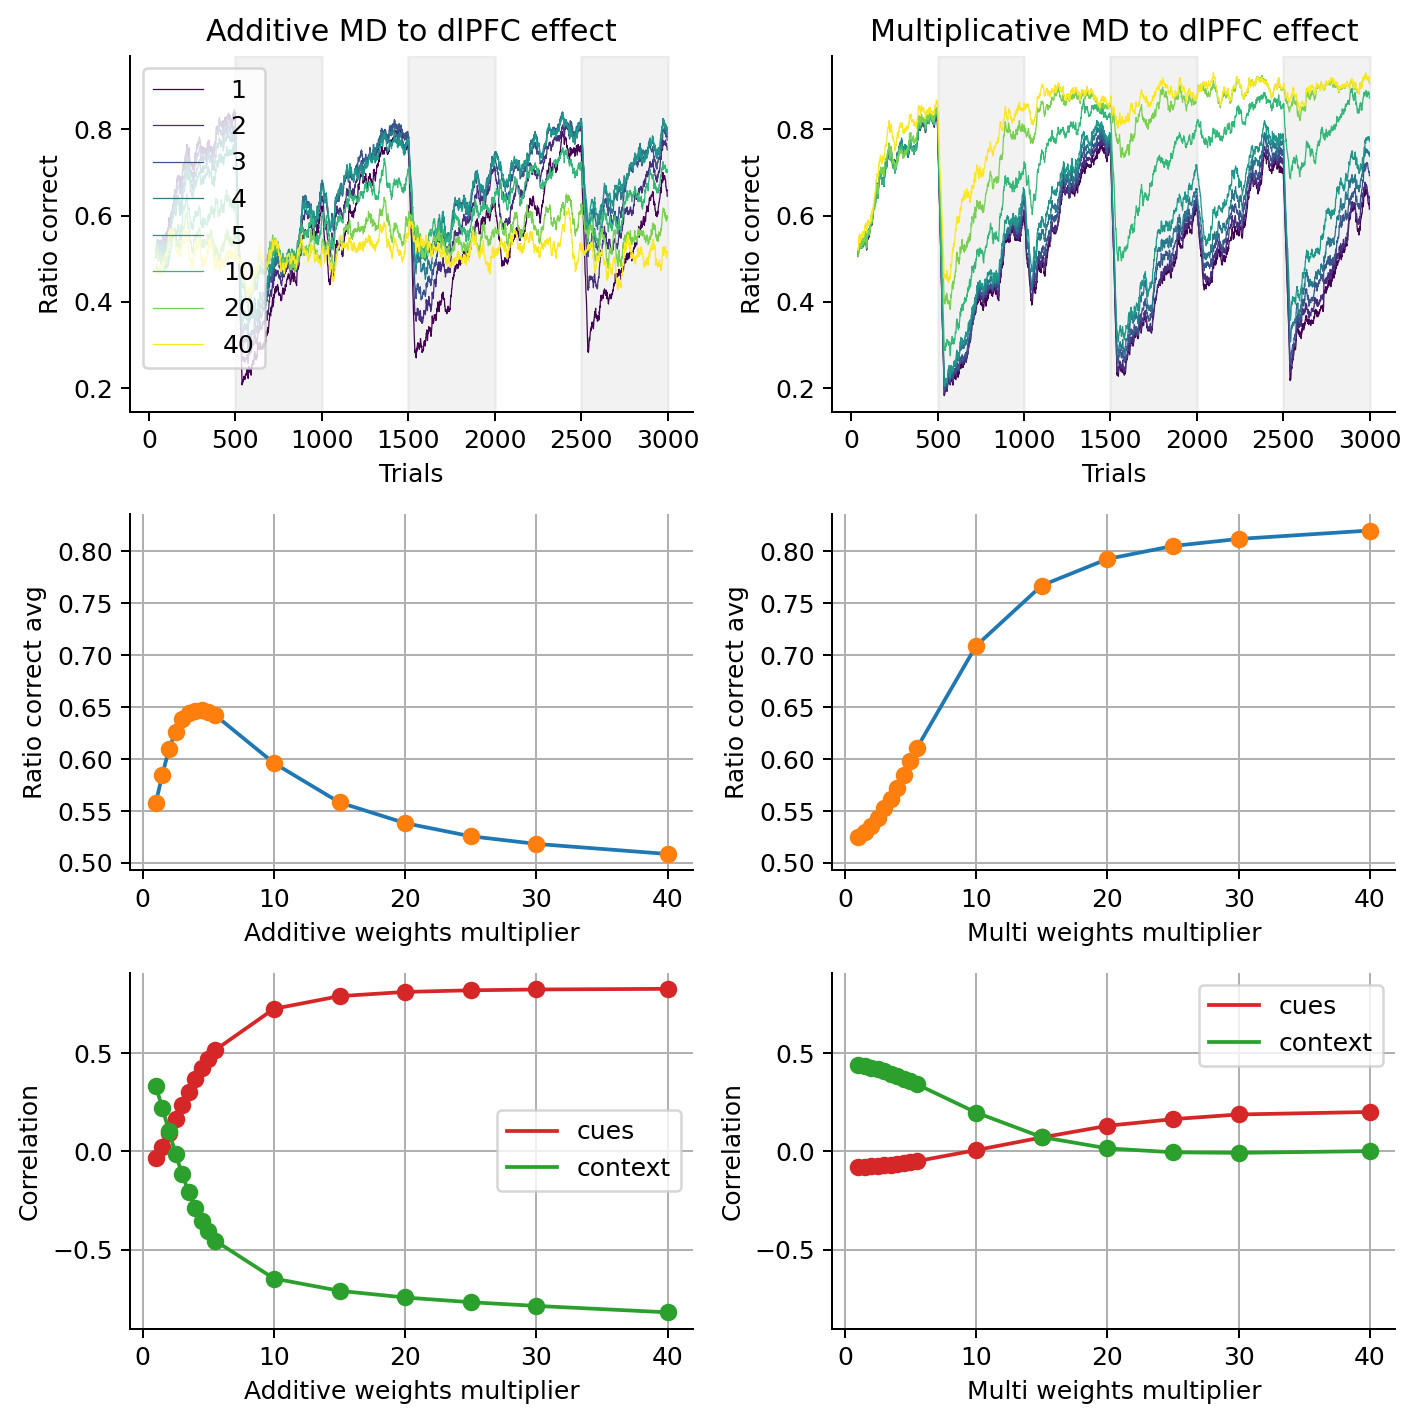

In [32]:

fig, axes = plt.subplots(3, 2, figsize=[8,8])

ax = axes[0,0]
for i, (spmean_copy, label) in enumerate(zip(means,labels)):
    if i in [0,2,4,6, 8, 10, 12, 15]:
        spmean = np.copy(spmean_copy)
        spmean[:40] = np.nan
        spmean[-40:] = np.nan
        ax.plot(range(len(spmean)), spmean, label=label[-2:], linewidth=0.5, color=cmap.to_rgba(i+1),)

tpb= 500
for ib in range(1, 6,2):
    ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')        
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Ratio correct')
ax.set_title('Additive MD to dlPFC effect')

ax = axes[0,1]
for i, (spmean_copy, label) in enumerate(zip(means_2,labels)):
    if i in [0,2, 4, 6,8, 10, 12,  15]:
        spmean = np.copy(spmean_copy)
        spmean[:40] = np.nan
        spmean[-40:] = np.nan
        ax.plot(range(len(spmean)), spmean, label=label[-2:], linewidth=0.5, color=cmap.to_rgba(i+1),)
for ib in range(1, 6,2):
    ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')        
ax.set_xlabel('Trials')
ax.set_ylabel('Ratio correct')
ax.set_title('Multiplicative MD to dlPFC effect')
# ax.legend()

ax = axes[1,0]
ax.plot(variable_values, [m.mean() for m in means])
ax.plot(variable_values, [m.mean() for m in means], 'o')
ax.set_ylabel('Ratio correct avg')
ax.set_xlabel('Additive weights multiplier')
ax.grid()

ax = axes[1,1]
ax.plot(variable_values, [m.mean() for m in means_2])
ax.plot(variable_values, [m.mean() for m in means_2], 'o')
ax.set_ylabel('Ratio correct avg')
ax.set_xlabel('Multi weights multiplier')
ax.grid()

## Correlations
color_one, color_two = 'tab:red', 'tab:green'
ax = axes[2,0]
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs], label= 'cues', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs], 'o', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs], label= 'context', color=color_two)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs], 'o', color=color_two)
ax.set_ylabel('Correlation')
ax.set_xlabel('Additive weights multiplier')
ax.grid()
ax.legend()

ax = axes[2,1]
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs2], label= 'cues', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs2], 'o', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs2], label= 'context', color=color_two)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs2], 'o', color=color_two)
ax.grid()
ax.set_ylabel('Correlation')
ax.set_xlabel('Multi weights multiplier')
ax.legend()
for i in range(3):
    axes[i,0].get_shared_y_axes().join(axes[i,0], axes[i,1])
fig.tight_layout()
plt.savefig('./exports/mul_vs_add_detailed.pdf', dpi=300)